In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn import preprocessing

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import BatchNormalization, LeakyReLU
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.callbacks.callbacks import EarlyStopping, ReduceLROnPlateau

import matplotlib.pyplot as plt

import time

Using TensorFlow backend.


In [0]:
dataset = pd.read_csv('/content/drive/My Drive/dataset_final_ncr_sm.csv')

In [0]:
dataset.shape

(2957263, 38)

In [0]:
dataset[0:5]

,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,sload,dload,spkts,dpkts,swin,stcpb,dtcpb,smeansz,dmeansz,res_bdy_len,sjit,djit,sintpkt,dintpkt,tcprtt,synack,ackdat,ct_state_ttl,ct_flw_http_mthd,ct_srv_src,ct_srv_dst,ct_dst_src_ltm,attack_cat,label
0,30.0,44760.0,15.0,50060.0,114.0,5.0,0.563389,917.0,354.0,254.0,252.0,2.0,1.0,3.0,1.198809e+04,4431.317304,10.0,8.0,255.0,2.461108e+09,8.642042e+08,91.0,44.0,0.0,4045.041227,124.801387,59.839865,71.882312,0.103581,0.060203,0.043379,1.0,0.795682,1.0,1.0,1.0,2,1
1,29.0,1578.0,14.0,62606.0,114.0,5.0,8.658444,5117.0,906106.0,254.0,252.0,2.0,337.0,5.0,4.761989e+03,828723.390887,113.0,679.0,255.0,3.047336e+09,1.140991e+09,45.0,1320.0,439169.0,3652.806216,1556.925461,77.236821,13.780183,0.132516,0.077684,0.054832,1.0,1.000000,1.0,1.0,1.0,7,1
2,37.0,101326.0,24.0,46132.0,114.0,5.0,0.299911,1470.0,1728.0,31.0,29.0,5.0,4.0,0.0,3.745111e+04,42812.703130,22.0,14.0,255.0,1.232964e+09,1.233261e+09,67.0,123.0,0.0,982.823809,32.533424,14.281476,23.014309,0.000713,0.000587,0.000126,0.0,0.000000,4.0,19.0,4.0,0,0
3,31.0,16307.0,12.0,30252.0,120.0,6.0,0.000002,252.0,0.0,254.0,0.0,0.0,0.0,0.0,4.486728e+08,0.000000,2.0,0.0,0.0,0.000000e+00,0.000000e+00,126.0,0.0,0.0,0.000000,0.000000,0.002252,0.000000,0.000000,0.000000,0.000000,2.0,0.000000,1.0,1.0,1.0,5,1
4,36.0,87088.0,27.0,61478.0,114.0,5.0,0.018423,1540.0,1644.0,31.0,29.0,4.0,4.0,0.0,6.270422e+05,674374.437500,16.0,18.0,255.0,1.872917e+09,1.877468e+09,96.0,91.0,0.0,72.697212,2.164304,1.205667,1.055882,0.000600,0.000470,0.000130,0.0,0.000000,15.0,14.0,7.0,0,0


In [0]:
X = dataset.iloc[:,0:36]
X.shape

(2957263, 36)

In [0]:
X[0:5]

,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,sload,dload,spkts,dpkts,swin,stcpb,dtcpb,smeansz,dmeansz,res_bdy_len,sjit,djit,sintpkt,dintpkt,tcprtt,synack,ackdat,ct_state_ttl,ct_flw_http_mthd,ct_srv_src,ct_srv_dst,ct_dst_src_ltm
0,30.0,44760.0,15.0,50060.0,114.0,5.0,0.563389,917.0,354.0,254.0,252.0,2.0,1.0,3.0,1.198809e+04,4431.317304,10.0,8.0,255.0,2.461108e+09,8.642042e+08,91.0,44.0,0.0,4045.041227,124.801387,59.839865,71.882312,0.103581,0.060203,0.043379,1.0,0.795682,1.0,1.0,1.0
1,29.0,1578.0,14.0,62606.0,114.0,5.0,8.658444,5117.0,906106.0,254.0,252.0,2.0,337.0,5.0,4.761989e+03,828723.390887,113.0,679.0,255.0,3.047336e+09,1.140991e+09,45.0,1320.0,439169.0,3652.806216,1556.925461,77.236821,13.780183,0.132516,0.077684,0.054832,1.0,1.000000,1.0,1.0,1.0
2,37.0,101326.0,24.0,46132.0,114.0,5.0,0.299911,1470.0,1728.0,31.0,29.0,5.0,4.0,0.0,3.745111e+04,42812.703130,22.0,14.0,255.0,1.232964e+09,1.233261e+09,67.0,123.0,0.0,982.823809,32.533424,14.281476,23.014309,0.000713,0.000587,0.000126,0.0,0.000000,4.0,19.0,4.0
3,31.0,16307.0,12.0,30252.0,120.0,6.0,0.000002,252.0,0.0,254.0,0.0,0.0,0.0,0.0,4.486728e+08,0.000000,2.0,0.0,0.0,0.000000e+00,0.000000e+00,126.0,0.0,0.0,0.000000,0.000000,0.002252,0.000000,0.000000,0.000000,0.000000,2.0,0.000000,1.0,1.0,1.0
4,36.0,87088.0,27.0,61478.0,114.0,5.0,0.018423,1540.0,1644.0,31.0,29.0,4.0,4.0,0.0,6.270422e+05,674374.437500,16.0,18.0,255.0,1.872917e+09,1.877468e+09,96.0,91.0,0.0,72.697212,2.164304,1.205667,1.055882,0.000600,0.000470,0.000130,0.0,0.000000,15.0,14.0,7.0


In [0]:
y = dataset.iloc[:,-2:]
y.shape

(2957263, 2)

In [0]:
y[0:5]

,attack_cat,label
0,2,1
1,7,1
2,0,0
3,5,1
4,0,0


In [0]:
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
# Pass parameter type = 'statistical' or 'minmax'
# Note: statistical is better for SVM and KNN.
def normalization(data, type='minmax'):
    if type == 'statistical':
        return stats.zscore(data)
    elif type == 'minmax':
        scaler = MinMaxScaler()
        return scaler.fit_transform(data)
    else:
        print('\n Norm type not found! \n')

In [0]:
X = normalization(X, 'statistical')

[[-4.58147326e-01  9.58136341e-03 -6.51654610e-01  6.79912372e-01
   5.07671624e-03  2.14523534e-01 -1.98496017e-02 -5.08820988e-02
  -2.05337385e-01  1.70556490e+00  2.98609551e+00 -9.82722709e-02
  -2.42856750e-01  5.55963929e-01 -3.44266194e-01 -5.24598650e-01
  -2.46918227e-01 -2.52324312e-01  8.92537477e-01  8.93965175e-01
  -2.32538180e-01 -2.20609866e-01 -6.12752767e-01 -8.98559553e-02
   7.51387148e-02 -1.65097754e-01 -4.78575520e-02 -7.36938916e-03
   1.88439752e+00  2.12597298e+00  1.49048513e+00  6.30673449e-01
   7.16679271e-01 -7.19489062e-01 -6.97751599e-01 -5.02331076e-01]
 [-5.96918646e-01 -1.19798383e+00 -8.00394526e-01  1.25800253e+00
   5.07671624e-03  2.14523534e-01  5.91954299e-01  4.86591062e-03
   5.44544975e+00  1.70556490e+00  2.98609551e+00 -9.82722709e-02
   5.66544728e+00  1.38880564e+00 -3.44317772e-01 -3.18862210e-01
   1.00330039e+00  5.28185149e+00  8.92537477e-01  1.30840621e+00
  -3.64431414e-02 -5.30269848e-01  3.29747069e+00  8.91391439e+00
   5.8600

In [0]:
y_attack_cat = dataset.iloc[:,-2]
y_attack_cat.shape

(2957263,)

In [0]:
y_attack_cat[0:5]

0    2
1    7
2    0
3    5
4    0
Name: attack_cat, dtype: int64

In [0]:
model = Sequential()
model.add(Dense(256, input_shape=(36,)))
model.add(BatchNormalization(momentum=0.8))
model.add(LeakyReLU(0.2))
model.add(Dropout(.4))
model.add(Dense(128))
model.add(BatchNormalization(momentum=0.8))
model.add(LeakyReLU(0.2))
model.add(Dropout(.4))
model.add(Dense(64))
model.add(BatchNormalization(momentum=0.8))
model.add(LeakyReLU(0.2))
model.add(Dropout(.4))
model.add(Dense(16))
model.add(BatchNormalization(momentum=0.8))
model.add(LeakyReLU(0.2))
model.add(Dropout(.4))
model.add(Dense(10, activation='softmax'))

In [0]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               9472      
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128)              

In [0]:
skf = StratifiedKFold(n_splits=5,shuffle = True)

time_CNN = []

cv_score1 = []
cv_score2 = []
all_history = []
y_pred_all = []
y_test_all = []

for train_index, test_index in skf.split(X, y_attack_cat):
     print("TRAIN:", train_index, "TEST:", test_index)

     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = y_attack_cat[train_index], y_attack_cat[test_index]

     s = time.clock()

     es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 5, 
                        restore_best_weights = True, verbose = 1)
     rlrop = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = 5, 
                               factor = 0.2, min_lr = 1e-6, verbose = 1)

     history = model.fit(X_train, y_train, epochs=50, batch_size=512,
               validation_split=0.2, verbose=1,
               callbacks = [es, rlrop],
               shuffle=True) 
     score1 = model.evaluate(X_test, y_test)
     print('SCORE1:\n', score1)
     y_pred = model.predict(X_test)

     e = time.clock() - s
     time_.append(e)
     print("Time taken by CNN model: ", e,"seconds \n")
     cv_score1.append(score1)
     all_history.append(history)
     y_pred_all.append(y_pred)
     y_test_all.append(y_test)

TRAIN: [      0       1       2 ... 2957259 2957261 2957262] TEST: [     17      20      23 ... 2957246 2957255 2957260]
Train on 1892648 samples, validate on 473162 samples
Epoch 1/50
1892648/1892648 [==============================] - 63s 33us/step - loss: 0.2372 - accuracy: 0.9145 - val_loss: 0.1945 - val_accuracy: 0.9236
Epoch 2/50
1892648/1892648 [==============================] - 65s 35us/step - loss: 0.2371 - accuracy: 0.9147 - val_loss: 0.1939 - val_accuracy: 0.9242
Epoch 3/50
1892648/1892648 [==============================] - 67s 35us/step - loss: 0.2369 - accuracy: 0.9146 - val_loss: 0.1948 - val_accuracy: 0.9241
Epoch 4/50
1892648/1892648 [==============================] - 66s 35us/step - loss: 0.2365 - accuracy: 0.9147 - val_loss: 0.1932 - val_accuracy: 0.9242
Epoch 5/50
1892648/1892648 [==============================] - 67s 36us/step - loss: 0.2369 - accuracy: 0.9146 - val_loss: 0.1946 - val_accuracy: 0.9242
Epoch 6/50
1892648/1892648 [==============================] - 66s 

"     lb = preprocessing.MultiLabelBinarizer()\n     y_testlb = lb.fit_transform(y_test)\n     y_predlb = lb.fit_transform(y_pred)\n     \n     f1score = f1_score(y_testlb, y_predlb, average='micro')\n     print('SCORE2:\n', f1score)\n     print('CONFUSION MATRIX \n', confusion_matrix(y_testlb, y_predlb))"

In [0]:
print('cv_score1\n',cv_score1)


cv_score1
 [[0.19468900871648542, 0.9241089224815369], [0.1951889345684783, 0.9241207838058472], [0.19496938531250355, 0.9236236810684204], [0.19467226848745325, 0.923873782157898], [0.1943627956897349, 0.9241815209388733]]
all_history
 [<keras.callbacks.callbacks.History object at 0x7f09bfd63518>, <keras.callbacks.callbacks.History object at 0x7f09bfcf2b70>, <keras.callbacks.callbacks.History object at 0x7f09bee307b8>, <keras.callbacks.callbacks.History object at 0x7f09bee30a58>, <keras.callbacks.callbacks.History object at 0x7f09bf8fa828>]
y_pred_all
 [array([[4.5551951e-14, 3.5631237e-15, 1.3542967e-18, ..., 1.3479119e-24,
        3.5538198e-18, 7.3458001e-16],
       [8.1621466e-04, 1.3980889e-01, 1.2457615e-01, ..., 1.5233843e-01,
        9.9650413e-02, 1.5200280e-02],
       [1.0145787e-03, 1.5776116e-01, 5.7411648e-02, ..., 3.1442549e-05,
        2.5254118e-01, 2.3201922e-01],
       ...,
       [1.0687488e-05, 8.2453716e-01, 5.1134848e-04, ..., 7.9869022e-07,
        3.1224871e

In [0]:
y_pred_class = []
for i in range(5):
  temp = []
  for j in range(len(y_pred_all[i])):
    #temp.append(list(y_pred_all[i]).index(max(y_pred_all[i][j])).any())
    temp.append(y_pred_all[i][j].argmax(axis=0))
  y_pred_class.append(temp)


4

In [0]:
for i in range(5):
  print(f1_score(y_test_all[i], y_pred_class[i], average='micro'))

0.9241089317325298
0.9241207669924745
0.9236236860748023
0.9238737885745589
0.9241815058533913


In [0]:
for i in range(5):
  print("Run ", i)
  print(confusion_matrix(y_test_all[i], y_pred_class[i]))

Run  0
[[426208     37     24      3      1    104   1711      1      0    268]
 [     4  10181    567   6368      1    397    433    842    979    228]
 [     2     87  13072   2204      8    261     34     69    248     15]
 [     1   2503    131  11043     20    311    179    195   1510    107]
 [     0    489     18    337  41955     59    101     87     33     17]
 [     0      0    224      0      0  11469    192    113      2      0]
 [     2    137    171    982      0    598  13250     66    735     59]
 [     0     72      4      0      0      2      0  11922      0      0]
 [     1    439    392   8004      0    678     95    101   4160    130]
 [     3     71     18   7515      0      0      2      0   3084   3307]]
Run  1
[[426305     28     29      5      0     61   1679      2      0    248]
 [     2  10207    399   6716      1    341    525    950    581    278]
 [     2    110  12850   2462      6    216     62    148    126     18]
 [     2   2442    131  11709     15

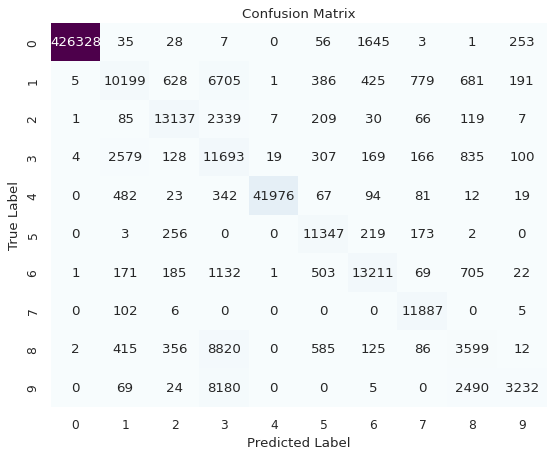

In [0]:
import seaborn as sn
def plot_confusion_matrix(cm, classes,
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues):
    sn.set(font_scale=1.0)
    sn.heatmap(cm, cmap="BuPu", annot=True,cbar=False,fmt='d')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.savefig('confusion.png')


cmatrix = confusion_matrix(y_test_all[4], y_pred_class[4], labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]) #5th iter has best Confusion Matrix
cm = pd.DataFrame(cmatrix, range(10), range(10))
plot_confusion_matrix(cm, ['Normal', 'Exploits', 'Reconnaissance', 'DoS', 'Generic', 'Shellcode', 'Fuzzers', 'Worms', 'Backdoors', 'Analysis'], normalize=False)

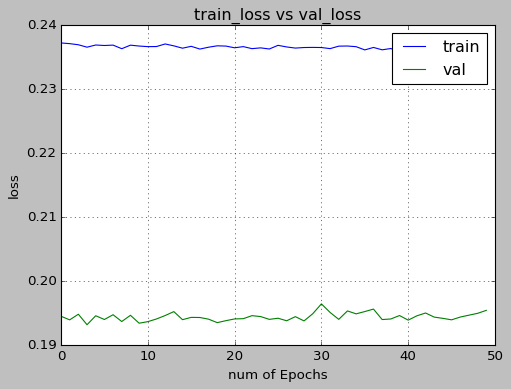

<Figure size 640x480 with 0 Axes>

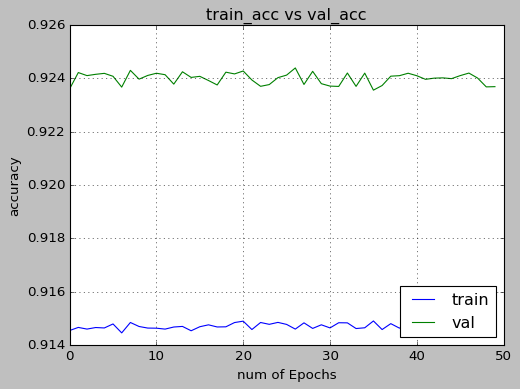

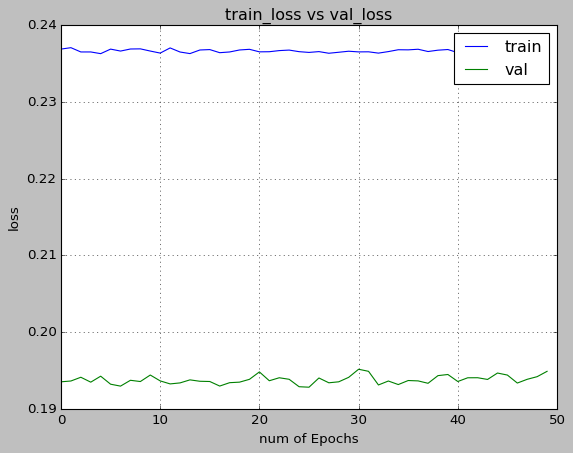

<Figure size 640x480 with 0 Axes>

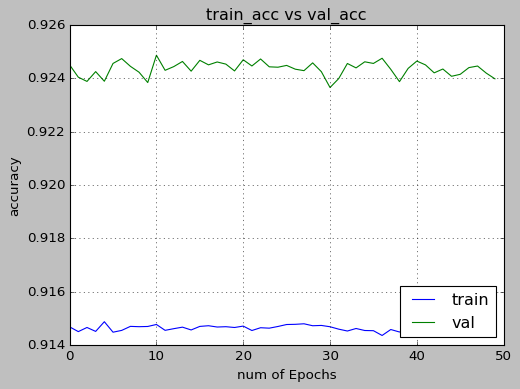

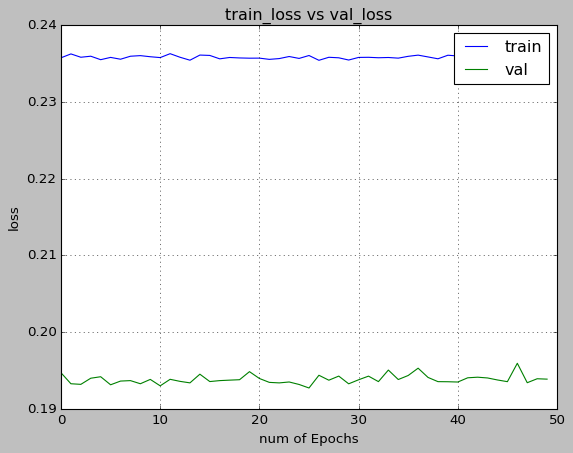

<Figure size 640x480 with 0 Axes>

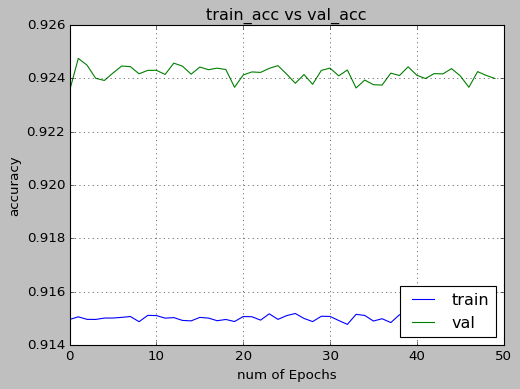

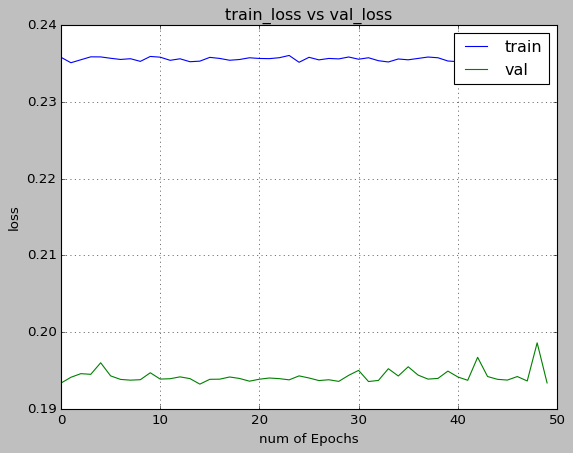

<Figure size 640x480 with 0 Axes>

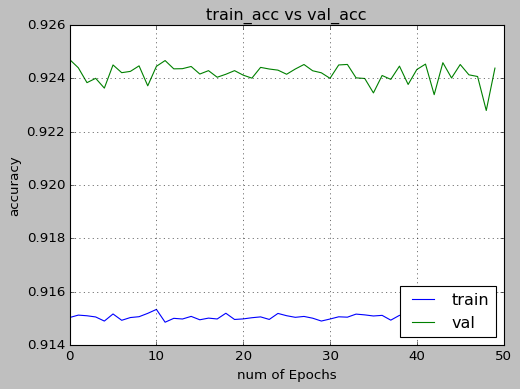

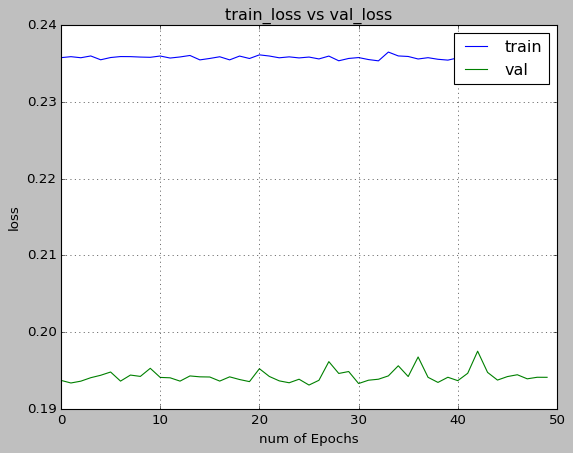

<Figure size 640x480 with 0 Axes>

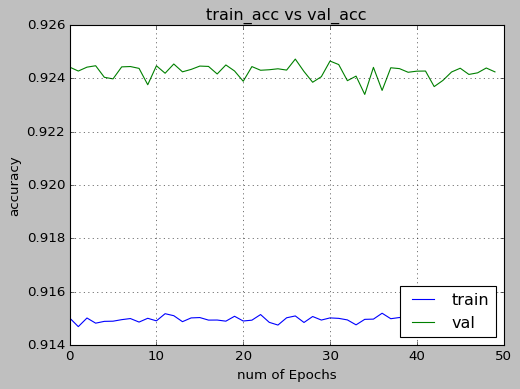

<Figure size 640x480 with 0 Axes>

In [0]:
i=1
for hist in all_history:
  train_loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  train_acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  xc = range(len(train_loss))
  plt.figure(1, figsize=(7, 5))
  plt.plot(xc, train_loss)
  plt.plot(xc, val_loss)
  plt.xlabel('num of Epochs')
  plt.ylabel('loss')
  plt.title('Loss:Train vs Val')
  plt.grid(True)
  plt.legend(['train', 'val'])
  plt.style.use(['classic'])
  plt.savefig('Loss_Plot'+str(i)+'.png')
  plt.show()
  plt.clf()

  plt.figure(2, figsize=(7, 5))
  plt.plot(xc, train_acc)
  plt.plot(xc, val_acc)
  plt.xlabel('num of Epochs')
  plt.ylabel('accuracy')
  plt.title('Accuracy:Train vs Val')
  plt.grid(True)
  plt.legend(['train', 'val'], loc=4)
  plt.style.use(['classic'])
  plt.savefig('Accuracy_Plot'+str(i)+'.png')
  plt.show()
  plt.clf()
  i+=1